In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def pam_gray(b):
    # pylint: disable=line-too-long
    r"""Maps a vector of bits to a PAM constellation points with Gray labeling.

    This recursive function maps a binary vector to Gray-labelled PAM
    constellation points. It can be used to generated QAM constellations.
    The constellation is not normalized.

    Input
    -----
    b : [n], NumPy array
        Tensor with with binary entries.

    Output
    ------
    : signed int
        The PAM constellation point taking values in
        :math:`\{\pm 1,\pm 3,\dots,\pm (2^n-1)\}`.

    Note
    ----
    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

In [3]:
def qam(num_bits_per_symbol, normalize=True):
    r"""Generates a QAM constellation.

    This function generates a complex-valued vector, where each element is
    a constellation point of an M-ary QAM constellation. The bit
    label of the ``n`` th point is given by the length-``num_bits_per_symbol``
    binary represenation of ``n``.

    Input
    -----
    num_bits_per_symbol : int
        The number of bits per constellation point.
        Must be a multiple of two, e.g., 2, 4, 6, 8, etc.

    normalize: bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    Output
    ------
    : :math:`[2^{\text{num_bits_per_symbol}}]`, np.complex64
        The QAM constellation.

    Note
    ----
    The bit label of the nth constellation point is given by the binary
    representation of its position within the array and can be obtained
    through ``np.binary_repr(n, num_bits_per_symbol)``.


    The normalization factor of a QAM constellation is given in
    closed-form as:

    .. math::
        \sqrt{\frac{1}{2^{n-2}}\sum_{i=1}^{2^{n-1}}(2i-1)^2}

    where :math:`n= \text{num_bits_per_symbol}/2` is the number of bits
    per dimension.

    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c

In [4]:
def pam(num_bits_per_symbol, normalize=True):
    r"""Generates a PAM constellation.

    This function generates a real-valued vector, where each element is
    a constellation point of an M-ary PAM constellation. The bit
    label of the ``n`` th point is given by the length-``num_bits_per_symbol``
    binary represenation of ``n``.

    Input
    -----
    num_bits_per_symbol : int
        The number of bits per constellation point.
        Must be positive.

    normalize: bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    Output
    ------
    : :math:`[2^{\text{num_bits_per_symbol}}]`, np.float32
        The PAM constellation.

    Note
    ----
    The bit label of the nth constellation point is given by the binary
    representation of its position within the array and can be obtained
    through ``np.binary_repr(n, num_bits_per_symbol)``.


    The normalization factor of a PAM constellation is given in
    closed-form as:

    .. math::
        \sqrt{\frac{1}{2^{n-1}}\sum_{i=1}^{2^{n-1}}(2i-1)^2}

    where :math:`n= \text{num_bits_per_symbol}` is the number of bits
    per symbol.

    This algorithm is a recursive implementation of the expressions found in
    Section 5.1 of [3GPPTS38211]_. It is used in the 5G standard.
    """ # pylint: disable=C0301

    try:
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be positive") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.float32)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b)

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol)
        pam_var = 1/(2**(n-1))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(pam_var)
    return c

In [5]:
#ref from class Constellation
def CreateConstellation(constellation_type, num_bits_per_symbol,normalize=True):
    r"""
    Constellation(constellation_type, num_bits_per_symbol, initial_value=None, normalize=True, center=False, trainable=False, dtype=tf.complex64, **kwargs)

    Constellation that can be used by a (de)mapper.

    This class defines a constellation, i.e., a complex-valued vector of
    constellation points. A constellation can be trainable. The binary
    representation of the index of an element of this vector corresponds
    to the bit label of the constellation point. This implicit bit
    labeling is used by the ``Mapper`` and ``Demapper`` classes.

    Parameters
    ----------
    constellation_type : One of ["qam", "pam", "custom"], str
        For "custom", the constellation points are randomly initialized
        if no ``initial_value`` is provided.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.

    initial_value : :math:`[2^\text{num_bits_per_symbol}]`, NumPy array or Tensor
        Initial values of the constellation points. If ``normalize`` or
        ``center`` are `True`, the initial constellation might be changed.

    normalize : bool
        If `True`, the constellation is normalized to have unit power.
        Defaults to `True`.

    center : bool
        If `True`, the constellation is ensured to have zero mean.
        Defaults to `False`.

    trainable : bool
        If `True`, the constellation points are trainable variables.
        Defaults to `False`.

    dtype : [tf.complex64, tf.complex128], tf.DType
        The dtype of the constellation.

    Output
    ------
    : :math:`[2^\text{num_bits_per_symbol}]`, ``dtype``
        The constellation.

    Note
    ----
    One can create a trainable PAM/QAM constellation. This is
    equivalent to creating a custom trainable constellation which is
    initialized with PAM/QAM constellation points.
    """
    num_bits_per_symbol = int(num_bits_per_symbol)
    if constellation_type=="qam":
        assert num_bits_per_symbol%2 == 0 and num_bits_per_symbol>0,\
            "num_bits_per_symbol must be a multiple of 2"
        num_bits_per_symbol = int(num_bits_per_symbol)

        points = qam(num_bits_per_symbol, normalize=normalize)
    if constellation_type=="pam":
        assert num_bits_per_symbol>0,\
            "num_bits_per_symbol must be integer"
        num_bits_per_symbol = int(num_bits_per_symbol)

        points = pam(num_bits_per_symbol, normalize=normalize)
    return points

In [8]:
def show(points, num_bits_per_symbol, labels=True, figsize=(7,7)):
    """Generate a scatter-plot of the constellation.

    Input
    -----
    labels : bool
        If `True`, the bit labels will be drawn next to each constellation
        point. Defaults to `True`.

    figsize : Two-element Tuple, float
        Width and height in inches. Defaults to `(7,7)`.

    Output
    ------
    : matplotlib.figure.Figure
        A handle to a matplot figure object.
    """
    maxval = np.max(np.abs(points))*1.05
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    plt.xlim(-maxval, maxval)
    plt.ylim(-maxval, maxval)
    plt.scatter(np.real(points), np.imag(points))
    ax.set_aspect("equal", adjustable="box")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid(True, which="both", axis="both")
    plt.title("Constellation Plot")
    if labels is True:
        for j, p in enumerate(points):
            plt.annotate(
                np.binary_repr(j, num_bits_per_symbol),
                (np.real(p), np.imag(p))
            )
    return fig

In [11]:
NUM_BITS_PER_SYMBOL = 2 # QPSK
#constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
points = CreateConstellation("qam", NUM_BITS_PER_SYMBOL)
points.shape


(4,)

In [12]:
points

array([ 0.70710677+0.70710677j,  0.70710677-0.70710677j,
       -0.70710677+0.70710677j, -0.70710677-0.70710677j], dtype=complex64)

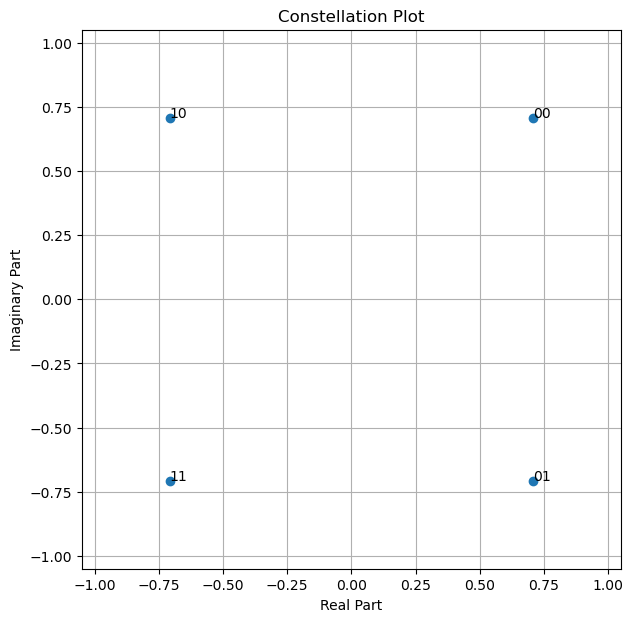

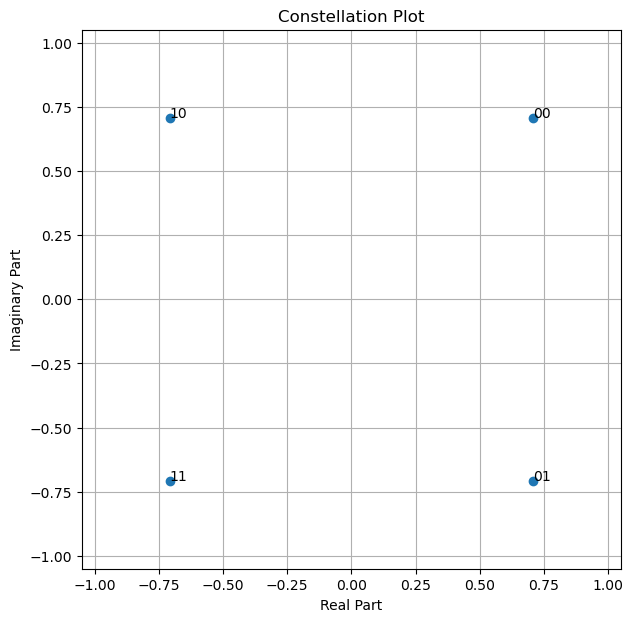

In [13]:
show(points, NUM_BITS_PER_SYMBOL)

We then need to setup a mapper to map bits into constellation points. The mapper takes as parameter the constellation.

We also need to setup a corresponding demapper to compute log-likelihood ratios (LLRs) from received noisy samples.

In [14]:
def BinarySource(shape):
    """BinarySource(dtype=tf.float32, seed=None, **kwargs)

    Layer generating random binary tensors.

    Parameters
    ----------
    dtype : tf.DType
        Defines the output datatype of the layer.
        Defaults to `tf.float32`.

    seed : int or None
        Set the seed for the random generator used to generate the bits.
        Set to `None` for random initialization of the RNG.

    Input
    -----
    shape : 1D tensor/array/list, int
        The desired shape of the output tensor.

    Output
    ------
    : ``shape``, ``dtype``
        Tensor filled with random binary values.
    """
    #tf.cast(tf.random.uniform(inputs, 0, 2, tf.int32), dtype=super().dtype)
    return np.random.randint(2, size=shape)
    #https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html#numpy.random.randint

In [15]:
BATCH_SIZE = 64 # How many examples are processed in parallel
shape = ([BATCH_SIZE,
                      1024])# Blocklength

bits = BinarySource(shape)

In [35]:
print("Shape of bits: ", bits.shape)

Shape of bits:  (64, 1024)


In [17]:
bits

array([[1, 0, 0, ..., 1, 1, 0],
       [1, 0, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 1],
       [1, 1, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1]])

In [76]:
class Mapper:
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 #dtype=tf.complex64,
                 #**kwargs
                ):
          self.num_bits_per_symbol = num_bits_per_symbol
          self.binary_base = 2**np.arange(num_bits_per_symbol-1, -1, -1, dtype=int) #array([2, 1], dtype=int32)
          self.points = CreateConstellation(constellation_type, num_bits_per_symbol) #(4,)
    
    def create_symbol(self, inputs):
        #inputs: (64, 1024) #batch_size, bits len
        new_shape = [-1] + [int(inputs.shape[-1] / self.num_bits_per_symbol), self.num_bits_per_symbol] #[-1, 512, 2]
        reinputs_reshaped = np.reshape(inputs, new_shape) #(64, 512, 2)
        # Convert the last dimension to an integer
        int_rep = reinputs_reshaped * self.binary_base #(64, 512, 2)
        int_rep = np.sum(int_rep, axis=-1) #(64, 512)
        print(int_rep.shape)
        # Map integers to constellation symbols
        #x = tf.gather(self.points, int_rep, axis=0)
        symbs_list = [self.points[val_int] for val_int in int_rep]
        symbols=np.array(symbs_list) #(64, 512) complex64
        print(symbols.dtype)
        return symbols


In [77]:
mapper=Mapper(constellation_type="qam", num_bits_per_symbol=2)

In [78]:
tmp=mapper.create_symbol(bits)

(64, 512)
complex64


In [79]:
tmp.shape

(64, 512)

In [75]:
tmp.dtype

dtype('complex64')

In [94]:
def complex_normal(shape, var=1.0):
    r"""Generates a tensor of complex normal random variables.

    Input
    -----
    shape : tf.shape, or list
        The desired shape.

    var : float
        The total variance., i.e., each complex dimension has
        variance ``var/2``.

    dtype: tf.complex
        The desired dtype. Defaults to `tf.complex64`.

    Output
    ------
    : ``shape``, ``dtype``
        Tensor of complex normal random variables.
    """
    # Half the variance for each dimension
    #var_dim = np.complex64(var/2)
    #var_dim = tf.cast(var, dtype.real_dtype)/tf.cast(2, dtype.real_dtype)
    #stddev = np.sqrt(var_dim)

    # Generate complex Gaussian noise with the right variance
    stddev = np.sqrt(var/2)
    xr = np.random.normal(loc=0.0, scale=stddev, size=shape)
    xi = np.random.normal(loc=0.0, scale=stddev, size=shape)
    x = xr + 1j*xi
    # xr = tf.random.normal(shape, stddev=stddev, dtype=dtype.real_dtype)
    # xi = tf.random.normal(shape, stddev=stddev, dtype=dtype.real_dtype)
    # x = tf.complex(xr, xi)

    return x

In [99]:
noise=complex_normal(tmp.shape, 1.0)

In [100]:
noise.shape

(64, 512)

In [101]:
noise.dtype

dtype('complex128')

In [102]:
noise[0,1]

(-0.06097630036949083+0.12455365076882209j)

In [103]:
y=tmp+noise

In [104]:
y.shape

(64, 512)

compute the noise power spectral density ratio $N_0$ from the energy per bit to noise power spectral density ratio $E_b/N_0$ in dB and a variety of parameters such as the coderate and the nunber of bits per symbol.

The function takes into account the number of coded bits per constellation symbol, the coderate, as well as possible additional overheads related to OFDM transmissions, such as the cyclic prefix and pilots.

The value of `No` is computed according to the following expression
$$N_o = \left(\frac{E_b}{N_o} \frac{r M}{E_s}\right)^{-1} $$

where $2^M$ is the constellation size, i.e., $M$ is the average number of coded bits per constellation symbol, $E_s=1$ is the average energy per constellation per symbol, $r\in(0,1]$ is the coderate, $E_b$ is the energy per information bit, and $N_o$ is the noise power spectral density.
    
For OFDM transmissions, $E_s$ is scaled according to the ratio between the total number of resource elements in a resource grid with non-zero energy and the number of resource elements used for data transmission. Also the additionally transmitted energy during the cyclic prefix is taken into account, as well as the number of transmitted streams per transmitter.

In [111]:
def ebnodb2no(ebno_db, num_bits_per_symbol, coderate):
    r"""Compute the noise variance `No` for a given `Eb/No` in dB.
    Input
    -----
    ebno_db : float
        The `Eb/No` value in dB.

    num_bits_per_symbol : int
        The number of bits per symbol.

    coderate : float
        The coderate used.

    resource_grid : ResourceGrid
        An (optional) instance of :class:`~sionna.ofdm.ResourceGrid`
        for OFDM transmissions.

    Output
    ------
    : float
        The value of :math:`N_o` in linear scale.
    """
    #ebno = tf.math.pow(tf.cast(10., dtype), ebno_db/10.)
    ebno = np.power(10, ebno_db/10.0)
    energy_per_symbol = 1
    tmp= (ebno * coderate * float(num_bits_per_symbol)) / float(energy_per_symbol)
    n0 = 1/tmp
    return n0


In [112]:
n0=ebnodb2no(ebno_db=10.0, num_bits_per_symbol=NUM_BITS_PER_SYMBOL, coderate=1.0)

In [113]:
n0

0.05

In [147]:
num_bits_per_symbol = 2
#num_bits_per_symbol.astype(np.float32)
float(num_bits_per_symbol)

2.0

In [148]:
np.power(4,2)

16

class SymbolLogits2LLRs
SymbolLogits2LLRs(method, num_bits_per_symbol, hard_out=False, with_prior=False, dtype=tf.float32, **kwargs)

    Computes log-likelihood ratios (LLRs) or hard-decisions on bits
    from a tensor of logits (i.e., unnormalized log-probabilities) on constellation points.
    If the flag ``with_prior`` is set, prior knowledge on the bits is assumed to be available.

With the "app" method, the LLR for the :math:`i\text{th}` bit
    is computed according to
$$
        LLR(i) = \ln\left(\frac{\Pr\left(b_i=1\lvert \mathbf{z},\mathbf{p}\right)}{\Pr\left(b_i=0\lvert \mathbf{z},\mathbf{p}\right)}\right) =\ln\left(\frac{
                \sum_{c\in\mathcal{C}_{i,1}} \Pr\left(c\lvert\mathbf{p}\right)
                e^{z_c}
                }{
                \sum_{c\in\mathcal{C}_{i,0}} \Pr\left(c\lvert\mathbf{p}\right)
                e^{z_c}
                }\right)$$

where $\mathcal{C}_{i,1}$ and $\mathcal{C}_{i,0}$ are the
sets of $2^K$ constellation points for which the $i\text{th}$ bit is
equal to 1 and 0, respectively. $\mathbf{z} = \left[z_{c_0},\dots,z_{c_{2^K-1}}\right]$ is the vector of logits on the constellation points, $\mathbf{p} = \left[p_0,\dots,p_{K-1}\right]$
is the vector of LLRs that serves as prior knowledge on the $K$ bits that are mapped to
a constellation point and is set to $\mathbf{0}$ if no prior knowledge is assumed to be available,
and $\Pr(c\lvert\mathbf{p})$ is the prior probability on the constellation symbol $c$:

In [149]:
num_bits_per_symbol

2

In [150]:
num_points = int(2**num_bits_per_symbol)

In [151]:
num_points

4

In [152]:
# Array composed of binary representations of all symbols indices
a = np.zeros([num_points, num_bits_per_symbol])
for i in range(0, num_points):
    a[i,:] = np.array(list(np.binary_repr(i, num_bits_per_symbol)),
                        dtype=np.int16)

# Compute symbol indices for which the bits are 0 or 1
c0 = np.zeros([int(num_points/2), num_bits_per_symbol]) #4/2, 2
c1 = np.zeros([int(num_points/2), num_bits_per_symbol])
for i in range(num_bits_per_symbol-1,-1,-1):
    c0[:,i] = np.where(a[:,i]==0)[0]
    c1[:,i] = np.where(a[:,i]==1)[0]

In [158]:
a

array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]])

In [154]:
c0.shape

(2, 2)

In [156]:
c0

array([[0., 0.],
       [1., 2.]])

In [157]:
c1

array([[2., 1.],
       [3., 3.]])

$$
        LLR(i) = \ln\left(\frac{\Pr\left(b_i=1\lvert y,\mathbf{p}\right)}{\Pr\left(b_i=0\lvert y,\mathbf{p}\right)}\right) =\ln\left(\frac{
                \sum_{c\in\mathcal{C}_{i,1}} \Pr\left(c\lvert\mathbf{p}\right)
                \exp\left(-\frac{1}{N_o}\left|y-c\right|^2\right)
                }{
                \sum_{c\in\mathcal{C}_{i,0}} \Pr\left(c\lvert\mathbf{p}\right)
                \exp\left(-\frac{1}{N_o}\left|y-c\right|^2\right)
                }\right)
$$
where $\mathcal{C}_{i,1}$ and $\mathcal{C}_{i,0}$ are the
    sets of constellation points for which the $i\text{th}$ bit is
    equal to 1 and 0, respectively. $\mathbf{p} = \left[p_0,\dots,p_{K-1}\right]$
    is the vector of LLRs that serves as prior knowledge on the $K$ bits that are mapped to
    a constellation point and is set to $\mathbf{0}$ if no prior knowledge is assumed to be available,
    and $\Pr(c\lvert\mathbf{p})$ is the prior probability on the constellation symbol $c$:

$$
        \Pr\left(c\lvert\mathbf{p}\right) = \prod_{k=0}^{K-1} \text{sigmoid}\left(p_k \ell(c)_k\right) $$

where $\ell(c)_k$ is the $k^{th}$ bit label of $c$, where 0 is replaced by -1.
The definition of the LLR has been chosen such that it is equivalent with that of logits. This is different from many textbooks in communications, where the LLR is defined as $LLR(i) = \ln\left(\frac{\Pr\left(b_i=0\lvert y\right)}{\Pr\left(b_i=1\lvert y\right)}\right)$.

With the "maxlog" demapping method, LLRs for the $i\text{th}$ bit are approximated like
$$
        \begin{align}
            LLR(i) &\approx\ln\left(\frac{
                \max_{c\in\mathcal{C}_{i,1}} \Pr\left(c\lvert\mathbf{p}\right)
                    \exp\left(-\frac{1}{N_o}\left|y-c\right|^2\right)
                }{
                \max_{c\in\mathcal{C}_{i,0}} \Pr\left(c\lvert\mathbf{p}\right)
                    \exp\left(-\frac{1}{N_o}\left|y-c\right|^2\right)
                }\right)\\
                &= \max_{c\in\mathcal{C}_{i,0}}
                    \left(\ln\left(\Pr\left(c\lvert\mathbf{p}\right)\right)-\frac{|y-c|^2}{N_o}\right) -
                 \max_{c\in\mathcal{C}_{i,1}}\left( \ln\left(\Pr\left(c\lvert\mathbf{p}\right)\right) - \frac{|y-c|^2}{N_o}\right)
                .
        \end{align} $$

In [ ]:
class Demapper:
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 hard_out=False,
                 with_prior=False,
                 #dtype=tf.complex64,
                 #**kwargs
                ):
        self.points = CreateConstellation(constellation_type, num_bits_per_symbol) #(4,)
        self.num_bits_per_symbol = num_bits_per_symbol
        self.with_prior = with_prior
        self.hard_out = hard_out
    
    def demap(self, inputs):
        if self.with_prior:
            y, prior, no = inputs
        else:
            y, no = inputs
        
        # Reshape constellation points to [1,...1,num_points]
        #points_shape = [1]*y.shape.rank + self.points.shape
        points_shape = [1]*len(y.shape) +list(points.shape) #[1,1]+[4] = [1, 1, 4]
        #points = tf.reshape(self.constellation.points, points_shape)
        points_reshape =np.reshape(points, points_shape)

        # Compute squared distances from y to all points
        # shape [...,n,num_points]
        #squared_dist = tf.pow(tf.abs(tf.expand_dims(y, axis=-1) - points_reshape), 2)
        ynew=np.expand_dims(y, axis=-1) #(64, 512, 1)
        squared_dist=((ynew-points_reshape)**2) #(64, 512, 4)
        
        # Compute exponents
        exponents = -squared_dist/no

        if self.with_prior:
            llr = self._logits2llrs([exponents, prior])
        else:
            llr = self._logits2llrs(exponents)

In [132]:
y.shape

(64, 512)

In [134]:
ynew=np.expand_dims(y, axis=-1)
ynew.shape

(64, 512, 1)

In [131]:
[1]*len(y.shape)

[1, 1]

In [119]:
y.shape

(64, 512)

In [126]:
points_shape=[1]*len(y.shape) +list(points.shape)

In [130]:
points_shape

[1, 1, 4]

In [127]:
points_reshape =np.reshape(points, points_shape)

In [129]:
points_reshape.shape

(1, 1, 4)

In [138]:
ynew.shape

(64, 512, 1)

In [140]:
ynew[0,1:4,:]

array([[ 0.64613047+0.83166042j],
       [-0.69431213-0.60379464j],
       [-1.66145764-0.74925408j]])

In [136]:
delta=ynew-points_reshape

In [137]:
delta.shape

(64, 512, 4)

In [141]:
delta[0, 1:4, :]

array([[-0.0609763 +0.12455365j, -0.0609763 +1.53876719j,
         1.35323724+0.12455365j,  1.35323724+1.53876719j],
       [-1.4014189 -1.3109014j , -1.4014189 +0.10331213j,
         0.01279463-1.3109014j ,  0.01279463+0.10331213j],
       [-2.36856441-1.45636085j, -2.36856441-0.04214731j,
        -0.95435087-1.45636085j, -0.95435087-0.04214731j]])

In [142]:
squared_dist=(delta**2)

In [143]:
squared_dist.shape

(64, 512, 4)

In [144]:
exponents = -squared_dist/n0

In [145]:
exponents.shape

(64, 512, 4)